In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='7bb82b7e-8a0f-4854-aac0-182e777a31bb', project_access_token='p-261bcd06faa60bd899ecbd4f9c1746c366285a8b')


# Time Series Forecasting using the NOAA Weather Data of JFK Airport (New York)

This notebook relates to the NOAA Weather Dataset - JFK Airport (New York). The dataset contains 114,546 hourly observations of 12 local climatological variables (such as temperature and wind speed) collected at JFK airport. This dataset can be obtained for free from the IBM Developer [Data Asset Exchange](https://developer.ibm.com/exchanges/data/all/jfk-weather-data/).

In this notebook we explore approaches to predicting future temperatures by using the time-series dataset.

### Table of Contents:
* [0. Prerequisites](#cell0)
* [1. Read the Cleaned Data](#cell1)
* [2. Explore Baseline Models](#cell2)
* [3. Train Statistical Time-series Analysis Models](#cell3)
* [Authors](#cell4)

<a id="cell0"></a>
### 0. Prerequisites

Before you run this notebook complete the following steps:
- Insert a project token
- Import required modules

#### Insert a project token

When you import this project from the Watson Studio Gallery, a token should be automatically generated and inserted at the top of this notebook as a code cell such as the one below:

```python
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='YOUR_PROJECT_ID', project_access_token='YOUR_PROJECT_TOKEN')
pc = project.project_context
```

If you do not see the cell above, follow these steps to enable the notebook to access the dataset from the project's resources:

* Click on `More -> Insert project token` in the top-right menu section

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)

* This should insert a cell at the top of this notebook similar to the example given above.

  > If an error is displayed indicating that no project token is defined, follow [these instructions](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/token.html?audience=wdp&context=data).

* Run the newly inserted cell before proceeding with the notebook execution below

#### Import required modules

Import and configure the required modules.

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib import pyplot as plt

<a id="cell1"></a>

### 1. Read the Cleaned Data

We start by reading the cleaned dataset that was created in the project notebook `Part 1 - Data Cleaning`. 

**Note:** if you haven't yet run this notebook, run it first; otherwise the cells below will not work.

In [3]:
def get_file_handle(fname):
    # Project data path for the raw data file
    data_path = project.get_file(fname)
    data_path.seek(0)
    return data_path

# Using pandas to read the data 
# Since the `DATE` column consists date-time information, we use Pandas parse_dates keyword for easier data processing
data_path = get_file_handle('jfk_weather_cleaned.csv')
data = pd.read_csv(data_path, parse_dates=['DATE'])
# Set date index
data = data.set_index(pd.DatetimeIndex(data['DATE']))
data.drop(['DATE'], axis=1, inplace=True)
data.head()

,visibility,dry_bulb_temp_f,wet_bulb_temp_f,dew_point_temp_f,relative_humidity,wind_speed,station_pressure,sea_level_pressure,precip,altimeter_setting,wind_direction_sin,wind_direction_cos
DATE,,,,,,,,,,,,
2010-01-01 01:00:00,6.0,33.0,32.0,31.0,92.0,0.0,0.0,29.97,8,29.99,0.01,29.99
2010-01-01 02:00:00,6.0,33.0,33.0,32.0,96.0,0.0,0.0,29.97,8,29.99,0.02,29.99
2010-01-01 03:00:00,5.0,33.0,33.0,32.0,96.0,0.0,0.0,29.97,8,29.99,0.00,29.99
2010-01-01 04:00:00,5.0,33.0,33.0,32.0,96.0,0.0,0.0,29.95,8,29.97,0.00,29.97
2010-01-01 05:00:00,5.0,33.0,32.0,31.0,92.0,0.0,0.0,29.93,8,29.96,0.00,29.95


For purposes of time-series modeling, we will restrict our analysis to a 2-year sample of the dataset to avoid overly long model-training times. 

In [4]:
sample = data['2016-01-01':'2018-01-01']
sample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17568 entries, 2016-01-01 00:00:00 to 2018-01-01 23:00:00
Data columns (total 12 columns):
visibility            17568 non-null float64
dry_bulb_temp_f       17568 non-null float64
wet_bulb_temp_f       17568 non-null float64
dew_point_temp_f      17568 non-null float64
relative_humidity     17568 non-null float64
wind_speed            17568 non-null float64
station_pressure      17568 non-null float64
sea_level_pressure    17568 non-null float64
precip                17568 non-null int64
altimeter_setting     17568 non-null float64
wind_direction_sin    17568 non-null float64
wind_direction_cos    17568 non-null float64
dtypes: float64(11), int64(1)
memory usage: 1.7 MB


#### Create Training/Validation/Test Splits

Before we attempt any time-series analysis and prediction, we should split the dataset into training, validation and test sets. We use a portion of the data for training, and a portion of _future_ data for our validation and test sets.

If we instead trained a model on the full dataset, the model would learn to be very good at making predictions on that particular dataset, essentially just copying the answers it knows. However, when presented with data the model _has not seen_ , it would perform poorly since it has not learned how to generalize its answers.

By training on a portion of the dataset and testing the model's performance on another portion of the dataset (which data the model has not seen in training), we try to avoid our models "over-fitting" the dataset and make them better at predicting temperatures given unseen, future data. This process of splitting the dataset and evaluating a model's performance on the validation and test sets is commonly known as [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)).

By default here we use 80% of the data for the training set and 10% each for validation and test sets.

In [5]:
def split_data(data, val_size=0.1, test_size=0.1):
    """
    Splits data to training, validation and testing parts
    """
    ntest = int(round(len(data) * (1 - test_size)))
    nval = int(round(len(data) * (1 - test_size - val_size)))

    df_train, df_val, df_test = data.iloc[:nval], data.iloc[nval:ntest], data.iloc[ntest:]
    
    return df_train, df_val, df_test


# Create data split
df_train, df_val, df_test = split_data(sample)

print('Total data size:      {} rows'.format(len(sample)))
print('Training set size:    {} rows'.format(len(df_train)))
print('Validation set size:  {} rows'.format(len(df_val)))
print('Test set size:        {} rows'.format(len(df_test)))

Total data size:      17568 rows
Training set size:    14054 rows
Validation set size:  1757 rows
Test set size:        1757 rows


<a id="cell2"></a>

### 2. Explore Baseline Models

In this section, we'll create a few simple predictive models of temperature, using shifting and rolling averages. These will serve as a baseline against which we can compare more sophisticated models.

Using values at recent timesteps (such as the most recent timestep `t-1` and second-most recent timestep `t-2`) to predict the current value at time `t` is what's known as persistence modeling, or using the last observed value to predict the next following value. These preceding timesteps are often referred to in time-series analysis as `lags`. So, the value at time `t-1` is known as the `1st lag` and the value at time `t-2` is the `2nd lag`.

We can also create baselines based on rolling (or moving) averages. This is a time-series constructed by averaging each lagged value up to the selected lag. For example, a 6-period (or 6-lag) rolling avearge is the average of the previous 6 hourly lags `t-6` to `t-1`.

Our baseline models will be:
1. `1st lag` - i.e. values at `t-1`
2. `2nd lag` - i.e. values at `t-2`
3. `6-lag` rolling average
4. `12-lag` rolling average

In [6]:
# define the column containing the data we wish to model - in this case Dry Bulb Temperature (F)
Y_COL = 'dry_bulb_temp_f'

# Use shifting and rolling averages to predict Y_COL (t)
n_in = 2
n_out = 1
features = [Y_COL]
n_features = len(features)

# create the baseline on the entire sample dataset.
# we will evaluate the prediction error on the validation set
baseline = sample[[Y_COL]].loc[:]
baseline['{} (t-1)'.format(Y_COL)] = baseline[Y_COL].shift(1)
baseline['{} (t-2)'.format(Y_COL)] = baseline[Y_COL].shift(2)
baseline['{} (6hr rollavg)'.format(Y_COL)] = baseline[Y_COL].rolling('6H').mean()
baseline['{} (12hr rollavg)'.format(Y_COL)] = baseline[Y_COL].rolling('12H').mean()
baseline.dropna(inplace=True)
baseline.head(10)

,dry_bulb_temp_f,dry_bulb_temp_f (t-1),dry_bulb_temp_f (t-2),dry_bulb_temp_f (6hr rollavg),dry_bulb_temp_f (12hr rollavg)
DATE,,,,,
2016-01-01 02:00:00,43.0,43.0,44.0,43.333333,43.333333
2016-01-01 03:00:00,42.0,43.0,43.0,43.000000,43.000000
2016-01-01 04:00:00,43.0,42.0,43.0,43.000000,43.000000
2016-01-01 05:00:00,42.0,43.0,42.0,42.833333,42.833333
2016-01-01 06:00:00,41.0,42.0,43.0,42.333333,42.571429
2016-01-01 07:00:00,41.0,41.0,42.0,42.000000,42.375000
2016-01-01 08:00:00,41.0,41.0,41.0,41.666667,42.222222
2016-01-01 09:00:00,40.0,41.0,41.0,41.333333,42.000000
2016-01-01 10:00:00,41.0,40.0,41.0,41.000000,41.909091


Next, we will plot data from our validation dataset to get a sense for how well these baseline models predict the next hourly temperature. Note thatd we only use a few days of data in order to make the plot easier to view.

In [7]:
# plot first 7 days of the validation set, 168 hours 
start = df_val.index[0]
end = df_val.index[167]
sliced = baseline[start:end]

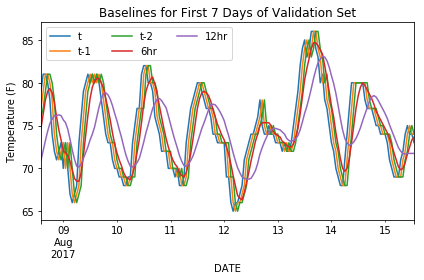

In [8]:
# Plot baseline predictions sample
cols = ['dry_bulb_temp_f', 'dry_bulb_temp_f (t-1)', 'dry_bulb_temp_f (t-2)', 'dry_bulb_temp_f (6hr rollavg)', 'dry_bulb_temp_f (12hr rollavg)']
sliced[cols].plot()

plt.legend(['t', 't-1', 't-2', '6hr', '12hr'], loc=2, ncol=3)
plt.title('Baselines for First 7 Days of Validation Set')
plt.ylabel('Temperature (F)')
plt.tight_layout()
plt.rcParams['figure.dpi'] = 100
plt.show()

#### Evaluate baseline models

As you can perhaps see from the graph above, the _lagged_ baselines appear to do a better job of forecasting temperatures than the _rolling average_ baselines.

In order to evaluate our baseline models more precisely, we need to answer the question _"how well do our models predict future temperature?"_. In regression problems involving prediction of a numerical value, we often use a measure of the difference between our predicted value and the actual value. This is referred to as an error measure or error metric. A common measure is the Mean Squared Error (MSE):

\begin{equation}
MSE = \frac{1}{n} \sum_{i=1}^{n}{(y_i - \hat y_i)^{2}}
\end{equation}

This is the average of the squared differences between predicted values $ \hat y $ and actual values $ y $.

Because the MSE is in "units squared" it can be difficult to interpet, hence the Root Mean Squared Error (RMSE) is often used:

\begin{equation}
RMSE = \sqrt {MSE} 
\end{equation}

This is the square root of the MSE, and is in the same units as the values $ y $. We can compare the RMSE (and MSE) values for different models and say that the model that has the lower MSE is better at predicting temperatures, all things equal. Note that MSE and RMSE will grow large quickly if the differences between predicted and actual values are large. This may or may not be a desired quality of your error measure. In this case, it is probably a good thing, since a model that makes large mistakes in temperature prediction will be much less useful than one which makes small mistakes.

Next, we calculate the RMSE measure for each of our baseline models, on the full validation set.

In [9]:
# Calculating baseline RMSE
start_val = df_val.index[0]
end_val = df_val.index[-1]
baseline_val = baseline[start_val:end_val]

baseline_y = baseline_val[Y_COL]
baseline_t1 = baseline_val['dry_bulb_temp_f (t-1)']
baseline_t2 = baseline_val['dry_bulb_temp_f (t-2)']
baseline_avg6 = baseline_val['dry_bulb_temp_f (6hr rollavg)']
baseline_avg12 = baseline_val['dry_bulb_temp_f (12hr rollavg)']

rmse_t1 = round(np.sqrt(mean_squared_error(baseline_y, baseline_t1)), 2)
rmse_t2 = round(np.sqrt(mean_squared_error(baseline_y, baseline_t2)), 2)
rmse_avg6 = round(np.sqrt(mean_squared_error(baseline_y, baseline_avg6)), 2)
rmse_avg12 = round(np.sqrt(mean_squared_error(baseline_y, baseline_avg12)), 2)

print('Baseline t-1 RMSE:            {0:.3f}'.format(rmse_t1))
print('Baseline t-2 RMSE:            {0:.3f}'.format(rmse_t2))
print('Baseline 6hr rollavg RMSE:    {0:.3f}'.format(rmse_avg6))
print('Baseline 12hr rollavg RMSE:   {0:.3f}'.format(rmse_avg12))

Baseline t-1 RMSE:            1.690
Baseline t-2 RMSE:            2.880
Baseline 6hr rollavg RMSE:    3.080
Baseline 12hr rollavg RMSE:   5.010


The RMSE results confirm what we saw in the graph above. It is clear that the _rolling average_ baselines perform poorly. In fact, the `t-2` lagged baseline is also not very good. It appears that the best baseline model is to simply use the current hour's temperature to predict the next hour's temperature!

Can we do better than this simple baseline using more sophisticated models?

<a id="cell3"></a>

### 2. Train Statistical Time-series Analysis Models


In the previous section, we saw that a simple `lag-1` baseline model performed reasonably well at forecasting temperature for the next hourly time step. This is perhaps not too surprising, given what we know about hourly temperatures. Generally, the temperature in a given hour will be quite closely related to the temperature in the previous hour. This phenomenon is very common in time-series analysis and is known as [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) - that is, the time series is `correlated` with previous values of itself. More precisely, the values at time `t` are correlated with lagged values (which could be `t-1`, `t-2` and so on).

Another thing we saw previously is the concept of _moving averages_. In this case the moving-average baseline was not that good at prediction. However it is common in many time-series for a moving average to capture some of the underlying structure and be useful for prediction.

In order to make our model better at predicting temperature, ideally we would want to take these aspects into account. Fortunately, the statistical community has a long history of analyzing time series and has created many different forecasting models.

Here, we will explore one called SARIMAX - the **S**easonal **A**uto**R**egressive **I**ntegrated **M**oving **A**verage with e**X**ogenous regressors model. 

This sounds like a very complex name, but if we look at the components of the name, we see that it includes `autocorrelation` (this is what auto regressive means) and `moving averages`, which are the components mentioned above. 

The SARIMAX model also allows including a _seasonal_ model component as well as handling *exogenous* variables, which are external to the time-series value itself. For example, for temperature prediction we may wish to take into account not just previous temperature values, but perhaps other weather features which may have an effect on temperature (such as humidity, rainfall, wind, and so on).

For the purposes of this notebook, we will not explore modeling of seasonal components or exogenous variables.

If we drop the "S" and "X" from the model, we are left with an [ARIMA model](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) (Auto-regressive Integrated Moving Average). This is a very commonly used model for time-series analysis and we will use it in this notebook by only specifying the relevant model components of the full SARIMAX model.

#### 2.1 Replicating a baseline model

As a starting point, we will see how we can use SARIMAX to create a simple model that in fact replicates one of the baselines we created previously. Auto-regression, as we have seen, means using values from preceding time periods to predict the current value. Recall that one of our baseline models was the `1st lag` or `t-1` model. In time-series analysis this is referred to as an **AR(1)** model, meaning an **A**uto-**R**egressive model for `lag 1`.

Technically, the AR(1) model is not exactly the same as our baseline model. A statistical time series model like SARIMAX learns a set of `weights` to apply to each component of the model. These weights are set so as to best fit the dataset. We can think of our baseline as setting the `weight` for the `t-1` lag to be exactly `1`. In practice, our time-series model will not have a weight of exactly `1` (though it will likely be very close to that), hence the predictions will be slightly different.

Now, lets fit our model to the dataset. First, we will set up the model inputs by taking the temperature column of our dataframe. We do this for training and validation sets.

In [10]:
X_train = df_train[Y_COL]
X_val = df_val[Y_COL]
X_both = np.hstack((X_train, X_val))

Here we created a variable called `X_both` to cover both the training and validation data. This is required later when we forecast values for our SARIMAX model, in order to give the model access to all the datapoints for which it must create forecasts. Note that the forecasts themselves will only be based on the _model weights_ learned from the training data (this is important for over-fitting as we have seen above)!

The SARIMAX model takes an argument called `order`: this specifies the components of the model and itself has 3 parts: `(p, d, q)`. `p` denotes the lags for the AR model and `q` denotes the lags for the MA model. We will not cover the `d` parameter here. Taken together this specifies the parameters of the [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) model portion of SARIMAX.

To create an AR(1) model, we set the `order` to be `(1, 0, 0)`. This sets up the AR model to be a `lag 1` model. Then, we fit our model on the training data and inspect a summary of the trained model. 

In [11]:
order = (1, 0, 0)
model_ar1 = SARIMAX(X_train, order=order)
results_ar1 = model_ar1.fit()
results_ar1.summary()

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:        dry_bulb_temp_f   No. Observations:                14054
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -27650.431
Date:                Wed, 25 Mar 2020   AIC                          55304.863
Time:                        11:06:13   BIC                          55319.964
Sample:                    01-01-2016   HQIC                         55309.889
                         - 08-08-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9996      0.000   4277.653      0.000       0.999       1.000
sigma2         2.9937      0.024    125.518      0.000       2.947       3.040
===================================================================================
Ljung-Box (Q):                    16360.93   Jarque-Bera (JB):              3656.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.15
Prob(H) (two-sided):                  0.26   Kurtosis:                         5.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

There's quite a lot of information printed out in the model summary above. Much of it is related to the statistical properties of our model.

The most important thing for now is to look at the second table, where we can see a `coef` value of `0.9996` for the weight `ar.L1`. This tells us the model has set a weight for the `1st lag` component of the AR model to be `0.9996`. This is almost `1` and hence we should expect the prediction results to indeed be close to our `t-1` baseline.

Let's create our model forecast on the validation dataset. We will then plot a few data points like we did with our baseline models (using 7 days of validation data) and compute the RMSE value based on the full validation set.

In [12]:
full_data_ar1 = SARIMAX(X_both, order=order)
model_forecast_ar1 = full_data_ar1.filter(results_ar1.params)

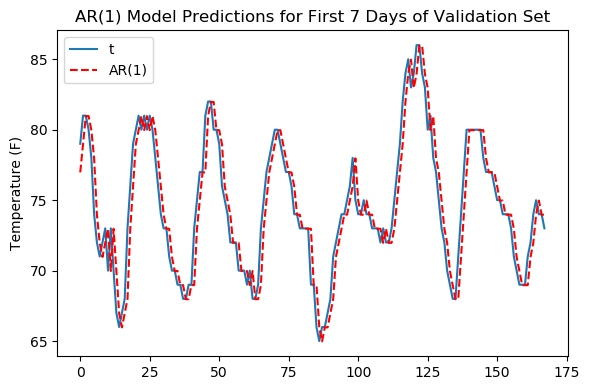

In [13]:
start = len(X_train)
end = len(X_both)
forecast_ar1 = model_forecast_ar1.predict(start=start, end=end - 1, dynamic=False)

# plot actual vs predicted values for the same 7-day window for easier viewing
plt.plot(sliced[Y_COL].values)
plt.plot(forecast_ar1[:168], color='r', linestyle='--')
plt.legend(['t', 'AR(1)'], loc=2)
plt.title('AR(1) Model Predictions for First 7 Days of Validation Set')
plt.ylabel('Temperature (F)')
plt.tight_layout()
plt.show()

We can see that the plot looks almost identical to the plot above, for the `t` and `t-1 baseline` values.

Next, we compute the RMSE values.

In [14]:
# compute print RMSE values
rmse_ar1 = np.sqrt(mean_squared_error(baseline_val[Y_COL], forecast_ar1))
print('AR(1) RMSE:                   {0:.3f}'.format(rmse_ar1))
print('Baseline t-1 RMSE:            {0:.3f}'.format(rmse_t1))

AR(1) RMSE:                   1.692
Baseline t-1 RMSE:            1.690


We can see that the RMSE values for the validation set also almost identical.

#### 2.2 Create a more complex model

One of our baseline models was a `lag 2` model, i.e. `t-2`. We saw that it performed a lot worse than the `t-1` baseline. Intuitively, this makes sense, since we are throwing away a lot of information about the most recent lag `t-1`. However, the `t-2` lag still provides some useful information. In fact, for temperature prediction it's likely that the last few hours can provide some value.

Fortunately, our ARIMA model framework provides an easy way to incorporate further lag information. We can construct a model that includes _both_ the `t-1` and `t-2` lags. This is an **AR(2)** model (meaning an auto-regressive model up to lag `2`). We can specify this with the model order parameter `p=2`.

In [15]:
order = (2, 0, 0)
model_ar2 = SARIMAX(X_train, order=order)
results_ar2 = model_ar2.fit()
results_ar2.summary()

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:        dry_bulb_temp_f   No. Observations:                14054
Model:               SARIMAX(2, 0, 0)   Log Likelihood              -26867.232
Date:                Wed, 25 Mar 2020   AIC                          53740.465
Time:                        11:06:14   BIC                          53763.117
Sample:                    01-01-2016   HQIC                         53748.005
                         - 08-08-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3242      0.006    220.175      0.000       1.312       1.336
ar.L2         -0.3248      0.006    -53.852      0.000      -0.337      -0.313
sigma2         2.6779      0.020    136.374      0.000       2.639       2.716
===================================================================================
Ljung-Box (Q):                     4350.76   Jarque-Bera (JB):              7579.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.01
Prob(H) (two-sided):                  0.75   Kurtosis:                         6.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This time, the results table indicates a weight for variable `ar.L1` _and_ `ar.L2`. Note the values are now quite different from `1` (or `0.5` say, for a simple equally-weighted model). Next, we compute the RMSE on the validation set. 

In [16]:
full_data_ar2 = SARIMAX(X_both, order=order)
model_forecast_ar2 = full_data_ar2.filter(results_ar2.params)

start = len(X_train)
end = len(X_both)
forecast_ar2 = model_forecast_ar2.predict(start=start, end=end - 1, dynamic=False)

# compute print RMSE values
rmse_ar2 = np.sqrt(mean_squared_error(baseline_val[Y_COL], forecast_ar2))
print('AR(2) RMSE:                   {0:.3f}'.format(rmse_ar2))
print('AR(1) RMSE:                   {0:.3f}'.format(rmse_ar1))
print('Baseline t-1 RMSE:            {0:.3f}'.format(rmse_t1))

AR(2) RMSE:                   1.526
AR(1) RMSE:                   1.692
Baseline t-1 RMSE:            1.690


We've improved the RMSE value by including information from the first two lags.

In fact, you will see that if you continue to increase the `p` parameter value, the RMSE will continue to decrease, indicating that a few recent lags provide useful information to our model.

#### 2.3 Incorporate moving averages

Finally, what if we also include moving average information in our model? The ARIMA framework makes this easy to do, by setting the order parameter `q`. A value of `q=1` specifies a **MA(1)** model (including the first lag `t-1`), while `q=6` would include all the lags from `t-1` to `t-6`.

Note that the moving average model component is a little different from the simple moving or rolling averages computed in the baseline models. The [definition of the MA model](https://en.wikipedia.org/wiki/Moving-average_model) is rather technical, but conceptually you can think of it as using a form of weighted moving average (compared to our baseline which would be a simple, unweighted average).

Let's add an MA(1) component to our AR(2) model.

In [17]:
order = (2, 0, 1)
model_ar2ma1 = SARIMAX(X_train, order=order)
results_ar2ma1 = model_ar2ma1.fit()
results_ar2ma1.summary()

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:        dry_bulb_temp_f   No. Observations:                14054
Model:               SARIMAX(2, 0, 1)   Log Likelihood              -26667.060
Date:                Wed, 25 Mar 2020   AIC                          53342.120
Time:                        11:06:15   BIC                          53372.322
Sample:                    01-01-2016   HQIC                         53352.172
                         - 08-08-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6697      0.015    114.448      0.000       1.641       1.698
ar.L2         -0.6700      0.015    -45.898      0.000      -0.699      -0.641
ma.L1         -0.3825      0.016    -23.348      0.000      -0.415      -0.350
sigma2         2.6026      0.019    139.868      0.000       2.566       2.639
===================================================================================
Ljung-Box (Q):                     2762.35   Jarque-Bera (JB):              8834.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.04
Prob(H) (two-sided):                  0.92   Kurtosis:                         6.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We see the results table shows an additional weight value for `ma.L1`, our MA(1) component. Next, we compare the RMSE to the other models and finally plot all the model forecasts together - _note_ we use a much smaller 48-hour window to make the plot readable for illustrative purposes. 

In [18]:
full_data_ar2ma1 = SARIMAX(X_both, order=order)
model_forecast_ar2ma1 = full_data_ar2ma1.filter(results_ar2ma1.params)

start = len(X_train)
end = len(X_both)
forecast_ar2ma1 = model_forecast_ar2ma1.predict(start=start, end=end - 1, dynamic=False)

# compute print RMSE values
rmse_ar2ma1 = np.sqrt(mean_squared_error(baseline_val[Y_COL], forecast_ar2ma1))
print('AR(2) MA(1) RMSE:             {0:.3f}'.format(rmse_ar2ma1))
print('AR(2) RMSE:                   {0:.3f}'.format(rmse_ar2))
print('AR(1) RMSE:                   {0:.3f}'.format(rmse_ar1))
print('Baseline t-1 RMSE:            {0:.3f}'.format(rmse_t1))

AR(2) MA(1) RMSE:             1.491
AR(2) RMSE:                   1.526
AR(1) RMSE:                   1.692
Baseline t-1 RMSE:            1.690


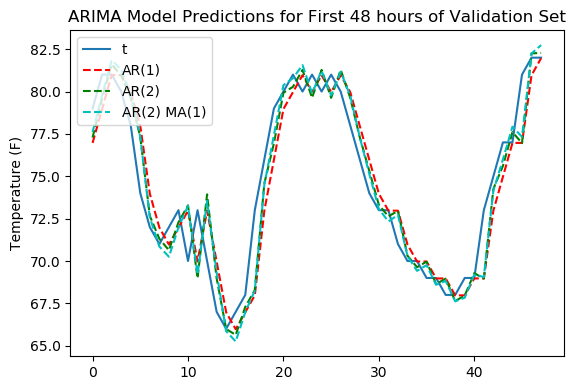

In [19]:
# plot actual vs predicted values for a smaller 2-day window for easier viewing
hrs = 48
plt.plot(sliced[Y_COL][:hrs].values)
plt.plot(forecast_ar1[:hrs], color='r', linestyle='--')
plt.plot(forecast_ar2[:hrs], color='g', linestyle='--')
plt.plot(forecast_ar2ma1[:hrs], color='c', linestyle='--')
plt.legend(['t', 'AR(1)', 'AR(2)', 'AR(2) MA(1)'], loc=2, ncol=1)
plt.title('ARIMA Model Predictions for First 48 hours of Validation Set')
plt.ylabel('Temperature (F)')
plt.tight_layout()
plt.show()

We've again managed to reduce the RMSE value for our model, indicating that adding the MA(1) component has improved our forecast!

Congratulations! You've applied the basics of time-series analysis for forecasting hourly temperatures. See if you can further improve the RMSE values by exploring the different values for the model parameters `p`, `q` and even `d`!

<a id="authors"></a> 
### Authors

This notebook was created by the [Center for Open-Source Data & AI Technologies](http://codait.org).

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>